# Weather Py
----------------------

#### Analysis of Trends - Jim Bentley

1. Random city data - All cities randomly chosen in the sample are evenly spread above, below the equator and accross the globe.

2. Temperatures appear stable in the Southern hemisphere.  The temperature drops the further north of the equator that you look at. This is backed up by the linear regression analysis.  The northern hemisphere has a strong positive correlation between temperature and latitude.  Compared to the southern hemisphere that has weaker correlation.
3. There is very weak or no corelation between latitude and other weather measures including:
    * Humidity 
    * Cloud Cover
    * Wind Speed
    
    This is for both the Northern and Southern hemispheres.

In [2]:
# import dependencies for the entire workbook
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import datetime
from scipy import stats

## Generate Cities List

 I performed a 'pip install citypy' to obtain the library. 

 Uniform random can be used to get uniformly distributed sample data

 600 cities chosen to ensure a sample set over 500
 

In [3]:
# Need the following library to get a list of cities
from citipy import citipy
from random import uniform

# Procedure to return a random lat and long coordinate
def newpoint():
   return uniform(-180,180), uniform(-90, 90)

# Find the closest city to each random coordinate (800)
cities = [] 
while len(cities) < 600:
    point = newpoint()
    city = citipy.nearest_city(point[0], point[1]).city_name
    # check if the city is not already chosen
    if city not in cities:
        cities.append(city)
    
# Check city count = 600
print(len(cities))

600


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).

Solution includes a check for duplicates - All cities in the list are unique

Only use cities with weather details returned from Open Weather. 

In [4]:
from api_keys import weather_api_key

url = "http://api.openweathermap.org/data/2.5/weather?"
units='imperial'

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

# set up lists to hold reponse info
citynum = []
cityname = []
citycountry = []
citytemp = []
cityhumidity = []
citylatitude = []
citylongitude = []
citycloudiness = []
citywindspeed = []

x = 0
valid_cities = 0

# Get weather data
for city in cities:
    x += 1
    try:
        response = requests.get(query_url + city).json()
        print(f"Processing record {x}: {response['name']} id={response['id']}")
        valid_cities +=1
        citynum.append(valid_cities)
        cityname.append(city)
        citycountry.append(response['sys']['country'])
        citytemp.append(response['main']['temp'])
        cityhumidity.append(response['main']['humidity'])
        citylatitude.append(response['coord']['lat'])
        citylongitude.append(response['coord']['lon'])
        citycloudiness.append(response['clouds']['all'])
        citywindspeed.append(response['wind']['speed'])
    except KeyError:
        print(f"Processing record {x}: {city} - No weather details available")
    
    # Break out of loop when we have enough weather records
    if valid_cities > 520:
        break

18693
Processing record 107: Gönc id=720494
Processing record 108: Rawson id=3839307
Processing record 109: Mwanza id=152224
Processing record 110: Boa Vista id=3664980
Processing record 111: Khanewal id=1174220
Processing record 112: Margate id=2643044
Processing record 113: Jurm id=1139085
Processing record 114: Bafoulabé id=2460755
Processing record 115: Mehamn id=778707
Processing record 116: Zharkent id=1520253
Processing record 117: Simplício Mendes id=3387620
Processing record 118: sorvag - No weather details available
Processing record 119: Puntarenas id=3622228
Processing record 120: Bāfq id=142255
Processing record 121: Necochea id=3430443
Processing record 122: Callaway id=4149635
Processing record 123: Sept-Îles id=6144312
Processing record 124: Dingle id=1714733
Processing record 125: Adrar id=2381972
Processing record 126: Francavilla Fontana id=3176603
Processing record 127: marcona - No weather details available
Processing record 128: Muzhi id=1498161
Processing record 

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
weather_dict = {
    "Number": citynum,
    "City": cityname,
    "Country": citycountry,
    "Latitude": citylatitude,
    "Longitude": citylongitude,
    "Temp": citytemp,
    "Humidity" : cityhumidity,
    "Cloudiness" : citycloudiness,
    "Windspeed" : citywindspeed 
}

weather_data = pd.DataFrame(weather_dict)
weather_data

,Number,City,Country,Latitude,Longitude,Temp,Humidity,Cloudiness,Windspeed
0,1,kruisfontein,ZA,-34.0033,24.7314,89.01,40,51,8.01
1,2,vila franca do campo,PT,37.7167,-25.4333,55.53,67,40,25.32
2,3,port alfred,ZA,-33.5906,26.8910,75.99,71,7,11.99
3,4,bredasdorp,ZA,-34.5322,20.0403,82.40,36,0,11.50
4,5,albany,US,42.6001,-73.9662,25.74,86,100,1.01
...,...,...,...,...,...,...,...,...,...
516,517,mehran,IR,33.1222,46.1646,62.60,27,0,4.61
517,518,gamboma,CG,-1.8764,15.8644,96.69,41,55,1.92
518,519,aneho,TG,6.2333,1.6000,91.40,58,20,10.36
519,520,eyl,SO,7.9803,49.8164,80.29,51,62,23.35


In [6]:
weather_data.to_csv("output_data\weather_data.csv", index=False)

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

Note: Most times I run this no records are found above 100%

In [7]:
high_humidity = weather_data.loc[weather_data['Humidity']>100]
high_humidity.head()

,Number,City,Country,Latitude,Longitude,Temp,Humidity,Cloudiness,Windspeed


In [8]:
#  Get the indices of cities that have humidity over 100%.
high_humidity_index = high_humidity.index

In [9]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = weather_data.drop(high_humidity_index, inplace=False)
len(clean_city_data)

521

In [10]:
# Reset index annd remove unecessary columns.
clean_city_data = clean_city_data.reset_index(inplace=False)
clean_city_data = clean_city_data[['City', 'Latitude', 'Temp', 'Humidity', 'Cloudiness', 'Windspeed']]
clean_city_data.head()

,City,Latitude,Temp,Humidity,Cloudiness,Windspeed
0,kruisfontein,-34.0033,89.01,40,51,8.01
1,vila franca do campo,37.7167,55.53,67,40,25.32
2,port alfred,-33.5906,75.99,71,7,11.99
3,bredasdorp,-34.5322,82.40,36,0,11.50
4,albany,42.6001,25.74,86,100,1.01


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

In [11]:
# store today's analysis date
now = datetime.date.today().strftime('%d-%b-%Y')

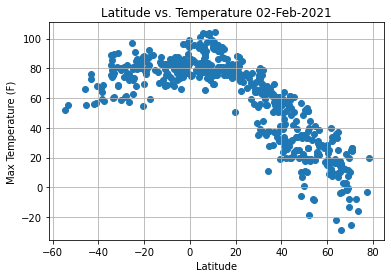

In [12]:
plt.scatter(clean_city_data.Latitude, clean_city_data.Temp)
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title(f"Latitude vs. Temperature {now}")
plt.grid(b=True)
plt.savefig("Images/LatitudeTemp.png")
plt.show()

### Notes for Analysis Report
* Temperature is stable for the southern hemisphere, but decreases significantly the further north you go above the equator.

## Latitude vs. Humidity Plot

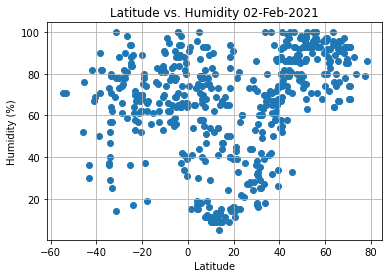

In [13]:
plt.scatter(clean_city_data.Latitude, clean_city_data.Humidity)
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Humidity {now}")
plt.grid(b=True)
plt.savefig("Images/LatitudeHumidity.png")
plt.show()

### Notes for Analysis Report
* Humidity appears to be lower just above the equator.

## Latitude vs. Cloudiness Plot

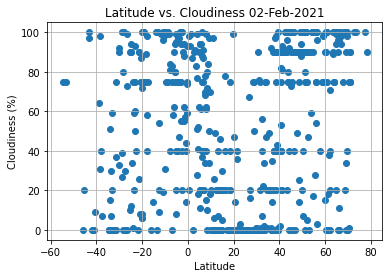

In [14]:
plt.scatter(clean_city_data.Latitude, clean_city_data.Cloudiness)
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Latitude vs. Cloudiness {now}")
plt.grid(b=True)
plt.savefig("Images/LatitudeCloud.png")
plt.show()

### Notes for Analysis Report
* Cloud cover appears scattered evenly accross the globe

## Latitude vs. Wind Speed Plot

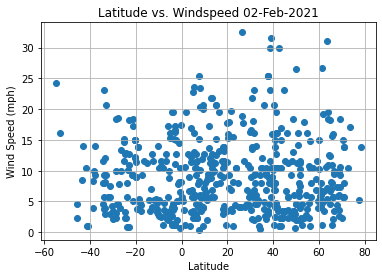

In [15]:
plt.scatter(clean_city_data.Latitude, clean_city_data.Windspeed)
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Latitude vs. Windspeed {now}")
plt.grid(b=True)
plt.savefig("Images/LatitudeWind.png")
plt.show()

### Notes for Analysis Report
* Wind speed does not seem to different at certain latitudes

## Linear Regression

In [16]:
# Split the dataset into hemispheres
north_hemisphere = clean_city_data.loc[clean_city_data.Latitude > 0]
south_hemisphere = clean_city_data.loc[clean_city_data.Latitude < 0]

print(f"North = {len(north_hemisphere)} records, South = {len(south_hemisphere)} records")

North = 362 records, South = 159 records


### Notes for Analysis Report
* It appears to be more cities located in the Northern Hemisphere.  Or more cities where weather details are recorded. 

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.8022879281589759


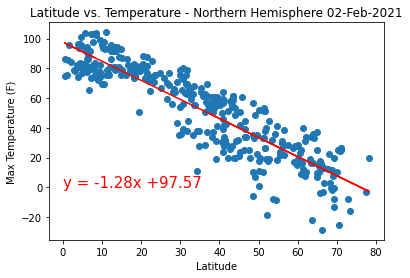

In [17]:
x_values = north_hemisphere.Latitude
y_values = north_hemisphere.Temp
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,0),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title(f"Latitude vs. Temperature - Northern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/NorthLatTempRegression.png")

plt.show()

### Notes for Analysis Report
* Strong positive correlation between temperature and latitude

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.2136704476273432


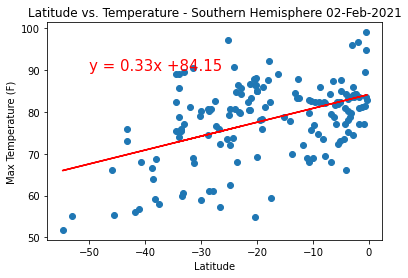

In [18]:
x_values = south_hemisphere.Latitude
y_values = south_hemisphere.Temp
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,90),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title(f"Latitude vs. Temperature - Southern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/SouthLatTempRegression.png")

plt.show()

### Notes for Analysis Report
* Weaker correlation in the southern hemisphere.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.3184353017891128


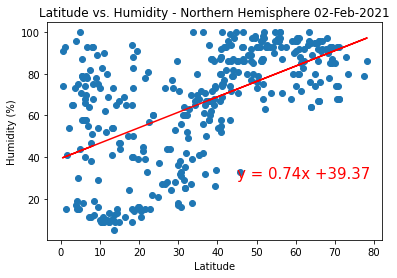

In [19]:
x_values = north_hemisphere.Latitude
y_values = north_hemisphere.Humidity
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(45,30),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Humidity - Northern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/NorthLatHumidRegression.png")

plt.show()

### Notes for Analysis Report
* Weak correlation between humidity and lattitude in the northern hemisphere.

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.022502852375176505


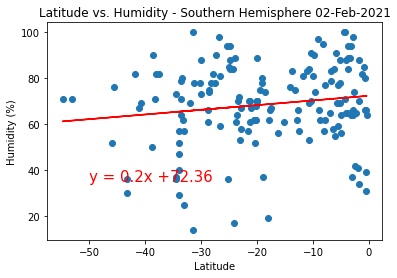

In [20]:
x_values = south_hemisphere.Latitude
y_values = south_hemisphere.Humidity
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,35),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Latitude vs. Humidity - Southern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/SouthLatHumidRegression.png")

plt.show()

### Notes for Analysis Report
* Again some, but weaker correlation in the southern hemisphere 

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.10929269751897049


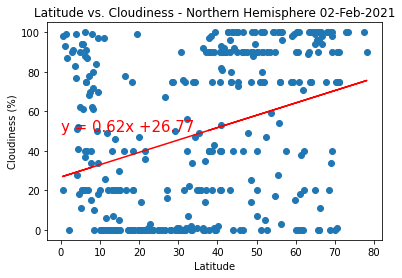

In [21]:
x_values = north_hemisphere.Latitude
y_values = north_hemisphere.Cloudiness
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Latitude vs. Cloudiness - Northern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/NorthLatCloudRegression.png")

plt.show()

### Notes for Analysis Report
* Weak correlation between latitude and cloud cover

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.13101044853228386


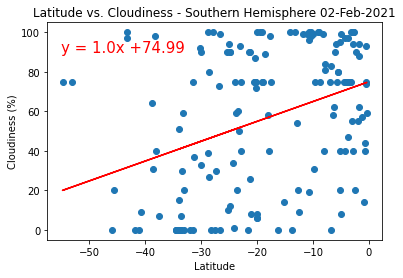

In [22]:
x_values = south_hemisphere.Latitude
y_values = south_hemisphere.Cloudiness
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,90),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Latitude vs. Cloudiness - Southern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/SouthLatCloudRegression.png")

plt.show()

### Notes for Analysis Report
* Weak correlation in southern hemisphere too

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.0029766542492444437


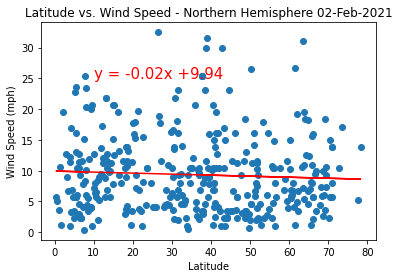

In [23]:
x_values = north_hemisphere.Latitude
y_values = north_hemisphere.Windspeed
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10,25),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Latitude vs. Wind Speed - Northern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/NorthLatWindRegression.png")

plt.show()

### Notes for Analysis Report
* No correlation

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.009739553191580512


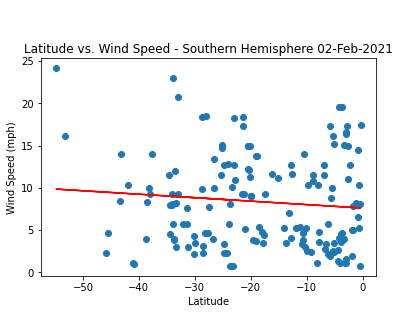

In [24]:
x_values = south_hemisphere.Latitude
y_values = south_hemisphere.Windspeed
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,30),fontsize=15,color="red")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Latitude vs. Wind Speed - Southern Hemisphere {now}")
# Print r value
print(f"The r-value is: {rvalue**2}")
plt.savefig("Images/SouthLatWindRegression.png")

plt.show()

### Notes for Analysis Report
* No correlation